In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import cross_val_score, KFold
sns.set()

В рассматриваемом наборе данных нужно определить стоимость автомобиля (price) в зависимости от значений следующих признаков:
    - mark (марка)
    - model (модель)
    - year (год выпуска)
    - mileage (пробег)
    - vol_engine (объём двигателя)
    - fuel (тип топлива)
    - city (город)
    - province (регион).
Так как целевой признак price является количественным, то нужно решить задачу регрессии.    

In [24]:
SIZE = 15
BIG_SIZE = 20

In [26]:
data = pd.read_csv('Car_Prices_Poland_Kaggle.csv') # считываем данные в датафрейм из csv файла 

In [17]:
data.head() # просмотр начала датафрейма

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900


In [208]:
data.shape # размер датафрейма (количество строк и столбцов)

(117927, 11)

In [210]:
data.dtypes # тип данных в столбцах

Unnamed: 0          int64
mark               object
model              object
generation_name    object
year                int64
mileage             int64
vol_engine          int64
fuel               object
city               object
province           object
price               int64
dtype: object

In [211]:
data.isna().sum() # проверка на наличие пропусков 

Unnamed: 0             0
mark                   0
model                  0
generation_name    30085
year                   0
mileage                0
vol_engine             0
fuel                   0
city                   0
province               0
price                  0
dtype: int64

In [27]:
# удаление малозначащих для предсказания цены автомобиля признаков
data.drop(columns=['Unnamed: 0', 'generation_name', 'city', 'province'], inplace=True)

In [28]:
# преобразуем категориальный признак year(год выпуска) в количественный - age(возраст)
data['age'] = 2022 - data['year']
data.drop('year', axis=1, inplace=True)
data.head()

,mark,model,mileage,vol_engine,fuel,price,age
0,opel,combo,139568,1248,Diesel,35900,7
1,opel,combo,31991,1499,Diesel,78501,4
2,opel,combo,278437,1598,Diesel,27000,7
3,opel,combo,47600,1248,Diesel,30800,6
4,opel,combo,103000,1400,CNG,35900,8


In [29]:
data[['mileage', 'vol_engine', 'age', 'price']].describe() # вычисление сводных показателей для количественных признаков

,mileage,vol_engine,age,price
count,1.179270e+05,117927.000000,117927.000000,1.179270e+05
mean,1.409768e+05,1812.057782,9.074741,7.029988e+04
std,9.236936e+04,643.613438,5.690135,8.482458e+04
min,0.000000e+00,0.000000,0.000000,5.000000e+02
25%,6.700000e+04,1461.000000,4.000000,2.100000e+04
50%,1.462690e+05,1796.000000,9.000000,4.190000e+04
75%,2.030000e+05,1995.000000,13.000000,8.360000e+04
max,2.800000e+06,7600.000000,77.000000,2.399900e+06


In [30]:
data[['mark', 'model', 'fuel']].describe() # вычисление сводных показателей для категориальных признаков

,mark,model,fuel
count,117927,117927,117927
unique,23,328,6
top,audi,astra,Gasoline
freq,12031,3331,61597


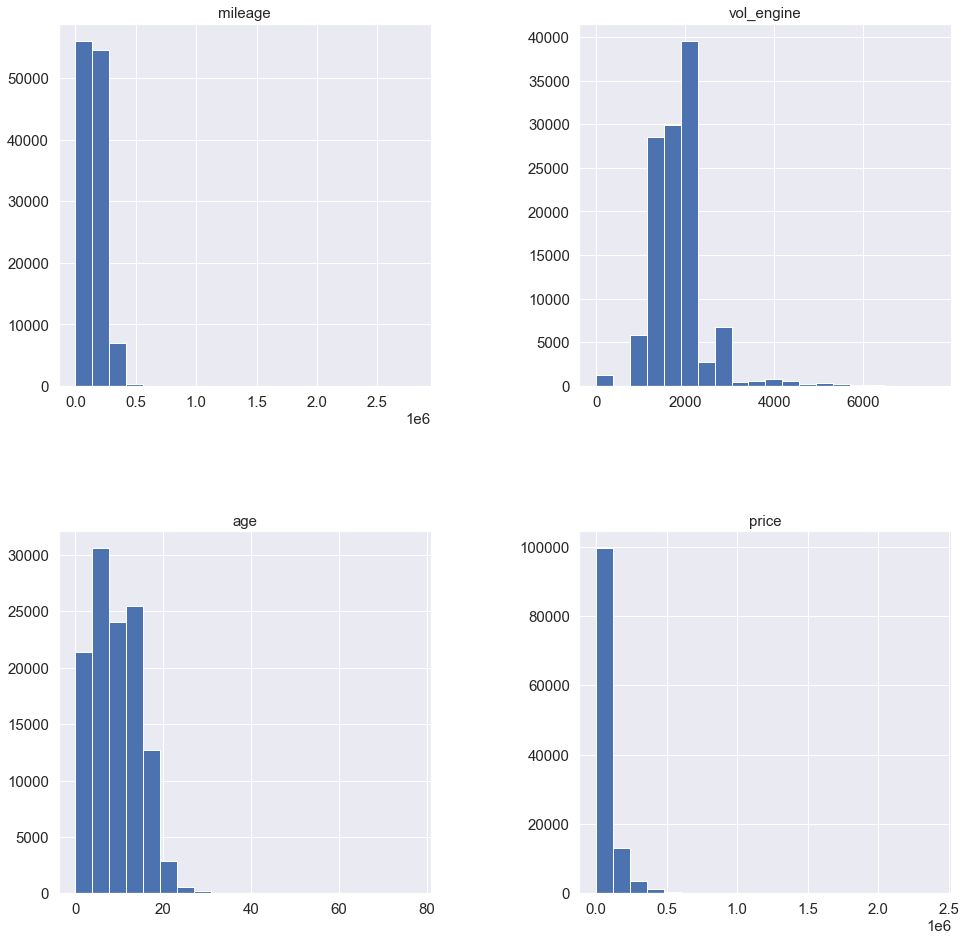

In [32]:
# построение гистограмм для количественных признаков
data_1 = data[['mileage', 'vol_engine', 'age', 'price']]
lst = list(data_1)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.hist(data_1.iloc[:, i - 1], bins=20)
    ax.set_title(lst[i - 1], fontsize=SIZE)
    plt.rc('xtick', labelsize=SIZE)
    plt.rc('ytick', labelsize=SIZE)

Как видно из гистограмм, в признаках присутствуют выбросы, поэтому нужно их обработать.

Text(0.5, 0, 'Mileage')

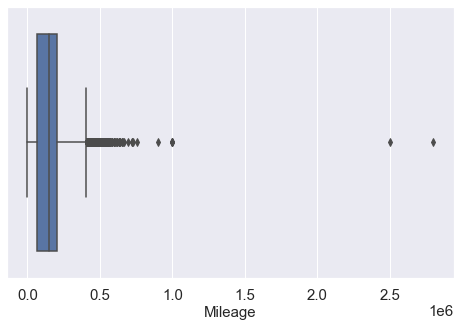

In [45]:
# Более подробно посмотреть на выбросы можно с помощью ящика с усами.
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['mileage'])
ax.set_xlabel('Mileage', fontsize=SIZE)

Text(0.5, 0, 'Vol_engine')

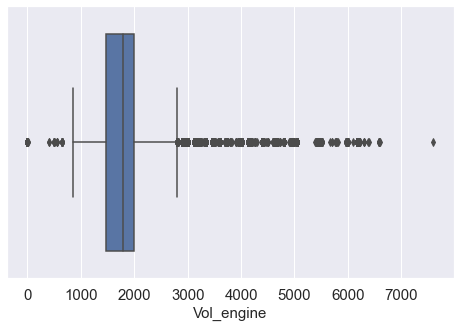

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['vol_engine'])
ax.set_xlabel('Vol_engine', fontsize=SIZE)

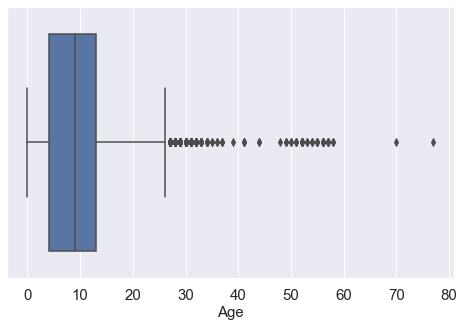

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['age'])
ax.set_xlabel('Age', fontsize=SIZE)
plt.rc('xtick', labelsize=SIZE)

Text(0.5, 0, 'Price')

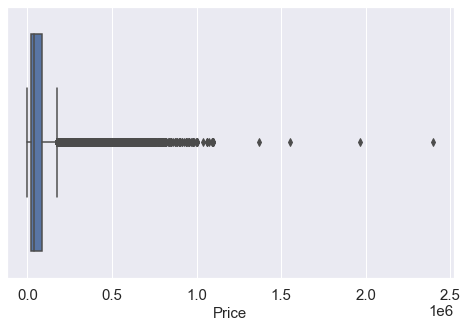

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(x=data['price'])
ax.set_xlabel('Price', fontsize=SIZE)

In [35]:
# Обнаруженные выбросы будем заменять на медианное значение признака
for feature in list(data[['mileage', 'age', 'price']]):
    Q1, Q2, Q3 = np.quantile(data[feature], [0.25, 0.5, 0.75]) # первый, второй и третий квартили
    delta = Q3 - Q1 # межквартильный размах
    mask = data[feature] > Q3 + 1.5 * delta
    data.loc[mask, feature] = Q2

In [37]:
Q1, Q2, Q3 = np.quantile(data['vol_engine'], [0.25, 0.5, 0.75]) 
delta = Q3 - Q1
mask = (data['vol_engine'] > Q3 + 1.5 * delta) | (data['vol_engine'] < Q1 - 1.5 * delta)
data.loc[mask, 'vol_engine'] = Q2

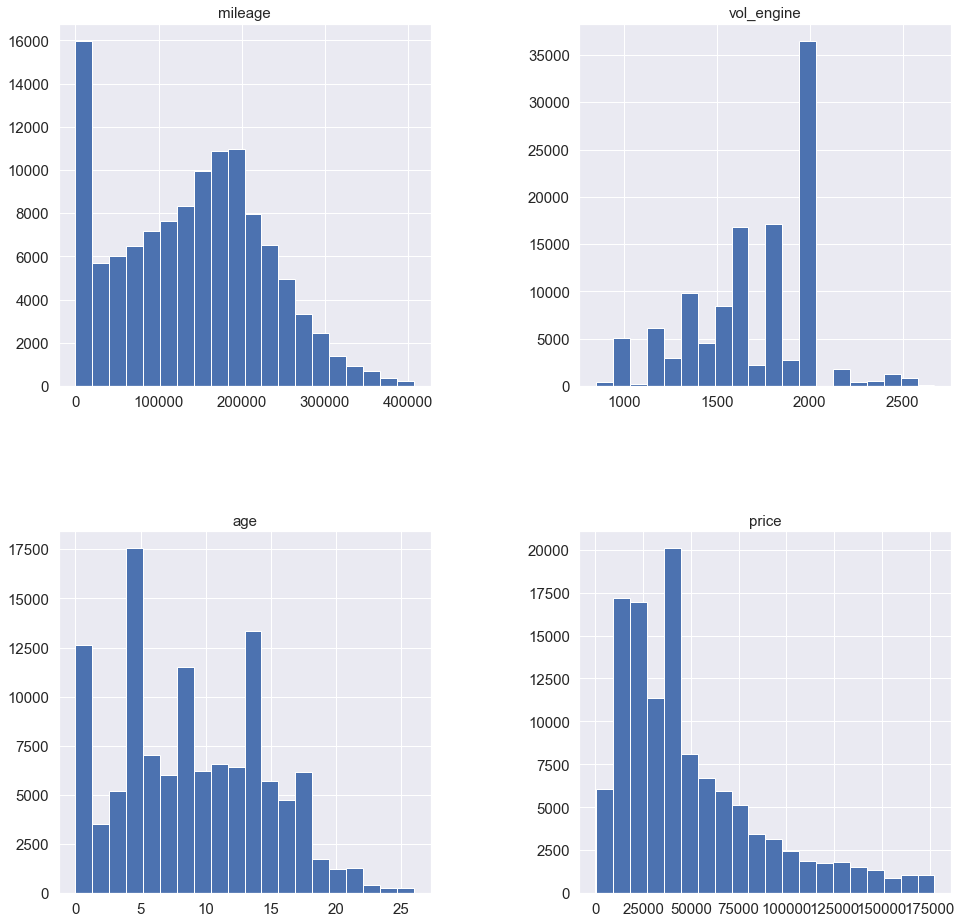

In [39]:
#гистограммы для количественных признаков после замены выбросов на медиану
data_1 = data[['mileage', 'vol_engine', 'age', 'price']]
lst = list(data_1)
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.hist(data_1.iloc[:, i - 1], bins=20)
    ax.set_title(lst[i - 1], fontsize=SIZE)
    plt.rc('xtick', labelsize=SIZE)
    plt.rc('ytick', labelsize=SIZE)

In [40]:
#сводные показатели для количественных признаков после замены выбросов
data[['mileage', 'vol_engine', 'age', 'price']].describe()

,mileage,vol_engine,age,price
count,117927.000000,117927.000000,117927.000000,117927.000000
mean,139691.919984,1695.648342,9.016273,49244.584769
std,89369.098422,322.264625,5.544627,37484.621611
min,0.000000,850.000000,0.000000,500.000000
25%,67000.000000,1496.000000,4.000000,21000.000000
50%,146269.000000,1796.000000,9.000000,41900.000000
75%,201658.000000,1969.000000,13.000000,65000.000000
max,407000.000000,2671.000000,26.000000,177500.000000


Text(0.5, 1.0, 'Матрица корреляции')

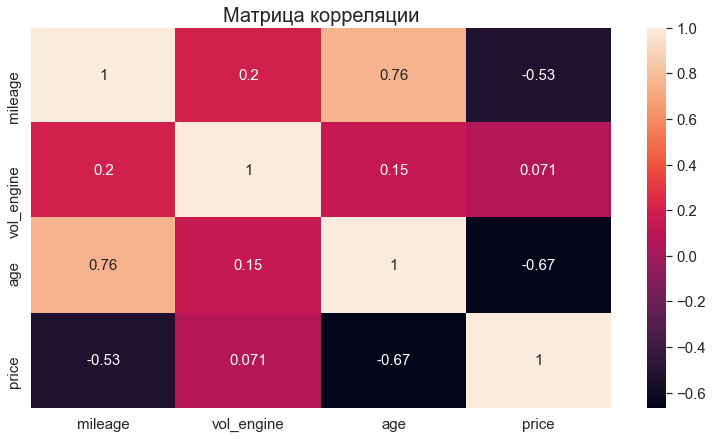

In [86]:
# построение матрицы корреляции признаков
fig, ax = plt.subplots(1, 1, figsize=(13, 7))
sns.heatmap(data[['mileage', 'vol_engine', 'age', 'price']].corr(), annot=True, cbar=True) 
plt.rc('font', size=SIZE)
plt.rc('ytick', labelsize=SIZE)
ax.set_title('Матрица корреляции', fontsize=BIG_SIZE)

Как видно из матрицы корреляции, признак mileage(пробег) имеет высокий коэффициент корреляции с признаком age(возраст), поэтому
его нужно удалить из матрицы признаков.

In [10]:
# удаление признака mileage с высоким коэффициентом корреляции(0.76)
data.drop('mileage', axis=1, inplace=True)

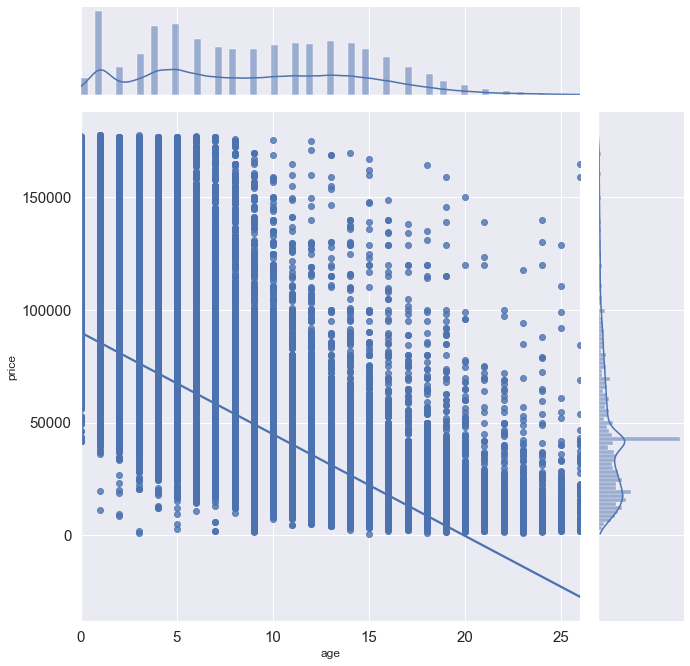

In [11]:
# Также из матрицы корреляции видна значительная линейная зависимость между признаками price и age, которую можно отобразить
# графически
grid = sns.jointplot(x=data['age'], y=data['price'], kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(10)
plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE)
plt.show()

In [252]:
# определяем количество автомобилей каждой марки
marks = data['mark'].value_counts().sort_values(ascending=False)
marks

audi             12031
opel             11914
bmw              11070
volkswagen       10848
ford              9664
mercedes-benz     7136
renault           6976
skoda             5888
toyota            5120
peugeot           5056
volvo             4384
hyundai           4032
kia               3744
nissan            3072
fiat              2880
seat              2848
mazda             2848
citroen           2720
honda             2176
mitsubishi        1120
mini              1088
alfa-romeo         704
chevrolet          608
Name: mark, dtype: int64

In [253]:
# доля автомобилей каждой марки от общего количества автомобилей
marks_rate = data['mark'].value_counts(normalize=True).sort_values(ascending=False)
np.round(marks_rate, 3)

audi            0.1020
opel            0.1010
bmw             0.0940
volkswagen      0.0920
ford            0.0820
mercedes-benz   0.0610
renault         0.0590
skoda           0.0500
toyota          0.0430
peugeot         0.0430
volvo           0.0370
hyundai         0.0340
kia             0.0320
nissan          0.0260
fiat            0.0240
seat            0.0240
mazda           0.0240
citroen         0.0230
honda           0.0180
mitsubishi      0.0090
mini            0.0090
alfa-romeo      0.0060
chevrolet       0.0050
Name: mark, dtype: float64

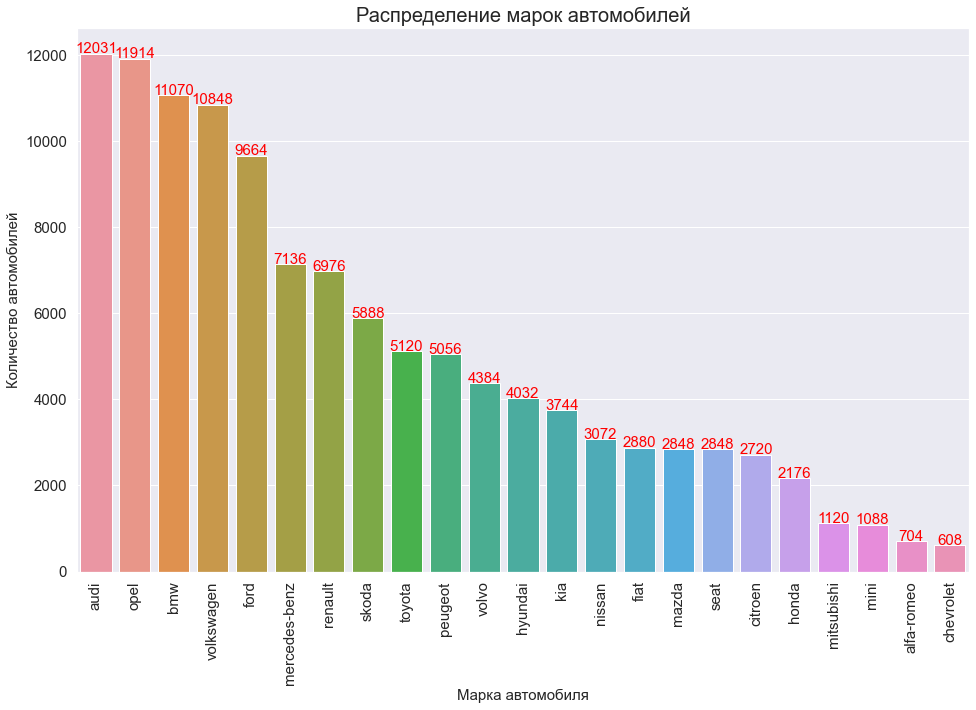

In [78]:
# отобразим на столбчатой диаграмме распределение марок автомобилей
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=marks.index, y=marks.values)
ax.set_xlabel('Марка автомобиля', fontsize=SIZE)
ax.set_ylabel('Количество автомобилей', fontsize=SIZE)
ax.set_title('Распределение марок автомобилей', fontsize=BIG_SIZE)
ax.set_xticklabels(marks.index, fontsize=SIZE, rotation=90)
plt.rc('ytick', labelsize=SIZE)
counter = 0
style = dict(size=SIZE, color='red')
for ind in marks.index:
    ax.text(counter, marks[ind] + 15, str(marks[ind]), ha = 'center', **style)
    counter +=1

In [12]:
# создание матрицы фиктивных переменных для марки авто и присоединение её к матрице признаков
mark_matrix = pd.get_dummies(data['mark'])
data = data.join(mark_matrix)

In [228]:
# определяем количество типов топлива
fuels = data['fuel'].value_counts().sort_values(ascending=False)
fuels

Gasoline    61597
Diesel      48476
LPG          4301
Hybrid       2621
Electric      885
CNG            47
Name: fuel, dtype: int64

In [229]:
# доля каждого типа топлива
fuels_rate = data['fuel'].value_counts(normalize=True).sort_values(ascending=False)
np.round(fuels_rate, 3)

Gasoline   0.5220
Diesel     0.4110
LPG        0.0360
Hybrid     0.0220
Electric   0.0080
CNG        0.0000
Name: fuel, dtype: float64

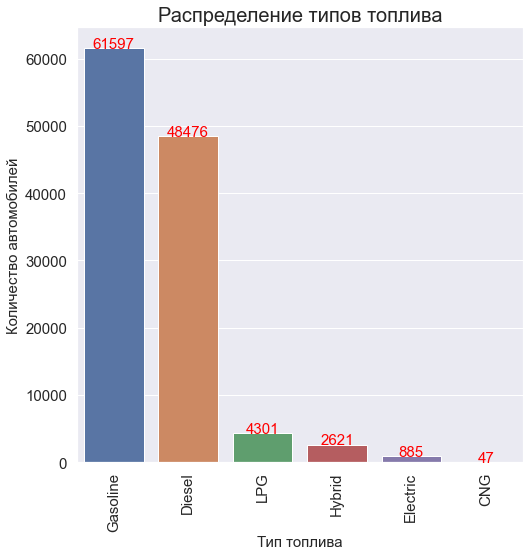

In [146]:
# отобразим на столбчатой диаграмме распределение типов топлива
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=fuels.index, y=fuels.values)
ax.set_xlabel('Тип топлива', fontsize=SIZE)
ax.set_ylabel('Количество автомобилей', fontsize=SIZE)
ax.set_title('Распределение типов топлива', fontsize=BIG_SIZE)
ax.set_xticklabels(fuels.index, fontsize=SIZE, rotation=90)
#plt.rc('xtick', labelsize=SIZE)
plt.rc('ytick', labelsize=SIZE)
counter = 0
style = dict(size=SIZE, color='red')
for ind in fuels.index:
    ax.text(counter, fuels[ind] + 15, str(fuels[ind]), ha = 'center', **style)
    counter +=1

In [13]:
# создание матрицы фиктивных переменных для типов топлива и присоединение её к матрице признаков
fuel_matrix = pd.get_dummies(data['fuel'])
data = data.join(fuel_matrix)

In [231]:
data['model'].unique() #модели автомобилей

array(['combo', 'vectra', 'adam', 'agila', 'ampera', 'antara', 'astra',
       'corsa', 'crossland-x', 'frontera', 'grandland-x', 'insignia',
       'vivaro', 'zafira', 'a3', 'karl', 'meriva', 'mokka', 'omega',
       'signum', 'tigra', '80', 'a1', 'a2', 'a4', 'a4-allroad', 'a5',
       'a6', 'a6-allroad', 'a7', 'a8', 'e-tron', 'q2', 'q3',
       'q4-sportback', 'q5', 'q7', 'q8', 'rs3', 'rs5', 'rs6', 'rs-q3',
       's3', 's5', 's8', 'sq5', 'tt', '3gt', '5gt', 'i3', 'm2', 'm3',
       'm4', 'm5', 'm8', 'seria-1', 'seria-2', 'seria-3', 'seria-4',
       'seria-5', 'seria-6', 'seria-7', 'seria-8', 'x1', 'x2', 'x3', 'x4',
       'x5', 'x5-m', 'x6', 'x6-m', 'x7', 'amarok', 'arteon', 'beetle',
       'caddy', 'california', 'caravelle', 'cc', 'crafter', 'eos', 'fox',
       'golf', 'golf-plus', 'golf-sportsvan', 'id4', 'jetta', 'lupo',
       'multivan', 'new-beetle', 'passat', 'passat-cc', 'phaeton', 'polo',
       'scirocco', 'sharan', 't-cross', 't-roc', 'tiguan',
       'tiguan-allspace'

In [14]:
# создание матрицы фиктивных переменных для моделей авто и присоединение её к матрице признаков
model_matrix = pd.get_dummies(data['model'])
data = data.join(model_matrix)

In [15]:
data.drop(columns=['mark', 'model', 'fuel'], inplace=True) # удаление признаков mark, model и fuel

In [16]:
data # набор данных после присоединения бинарных признаков

,vol_engine,price,age,alfa-romeo,audi,bmw,chevrolet,citroen,fiat,ford,...,xc-40,xc-60,xc-70,xc-90,xceed,xsara-picasso,yaris,yeti,zafira,zoe
0,1248.0,35900.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1499.0,78501.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1598.0,27000.0,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1248.0,30800.0,6.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1400.0,35900.0,8.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117922,1969.0,41900.0,2.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
117923,1969.0,41900.0,5.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
117924,1969.0,135000.0,6.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
117925,1969.0,154500.0,5.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [17]:
# масштабирование количественных признаков (кроме целевого)
scaler = StandardScaler()
data[['vol_engine', 'age']] = scaler.fit_transform(data[['vol_engine', 'age']])

In [18]:
# теперь среднее значение стандартизированных признаков 0, а стандартное отклонение 1
pd.set_option('display.float_format', lambda x: '%0.4f' % x)
data[['vol_engine', 'age']].describe()

,vol_engine,age
count,117927.0000,117927.0000
mean,0.0000,-0.0000
std,1.0000,1.0000
min,-2.5813,-1.6261
25%,-0.6186,-0.9047
50%,0.2929,-0.0029
75%,0.8185,0.7185
max,3.3311,3.0631


In [19]:
features = data.drop('price', axis=1) # матрица признаков
target = data['price'] # целевой вектор

In [20]:
# для решения задачи регрессии будем использовать модель на основе взвешенного алгоритма k ближайших соседей
model = KNeighborsRegressor(n_neighbors=11, weights='distance')

In [21]:
# для оценки эффективности работы модели используется перекрёстная проверка
kf = KFold(n_splits=5, shuffle=True, random_state=1) # количество блоков в перекрёстной проверке
cv_results = cross_val_score(model, features, target, cv=kf, scoring='r2', n_jobs=-1)
np.round(cv_results.mean(), 2)

0.8

Полученное значение коэффициента детерминации 0.8 свидетельствует о том, что модель на основе взвешенного алгоритма k ближайших соседей со значением параметра n_neighbors=11 (количество соседей) хорошо справляется с задачей предсказания цены автомобиля, располагая такими признаками как объём двигателя, возраст, марка и модель. Дальнейшее увеличение значения параметра n_neighbors
не привело к значительному улучшению коэффициента детерминации.